# Problem Statment: Brain Tumor Classification using ResNet50
This project implements a brain tumor classification model using the ResNet50 architecture. The dataset is processed, augmented, and used to train a deep learning model to classify brain tumors into multiple categories. 

In [1]:
import os
import cv2
import random
import numpy as np
from sklearn.utils import shuffle ,class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

2025-09-13 12:02:04.727274: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load data: each subfolder under data_dir is a class

data_dir = "/Users/temp_user/ml/ComputerVision/medicalImageClassification/Brain-Tumor-Classification-DataSet/Training"
class_names = [i for i in os.listdir(data_dir)]
print(class_names)

# convert string labels to numerical labels using dic
class_names_label = {j: i for i, j in enumerate(class_names)}
print(class_names_label)

['no_tumor', 'meningioma_tumor', 'glioma_tumor', 'pituitary_tumor']
{'no_tumor': 0, 'meningioma_tumor': 1, 'glioma_tumor': 2, 'pituitary_tumor': 3}


In [3]:
# preprocess images

datasets=['/Users/temp_user/ml/ComputerVision/medicalImageClassification/Brain-Tumor-Classification-DataSet/Training' , 
          '/Users/temp_user/ml/ComputerVision/medicalImageClassification/Brain-Tumor-Classification-DataSet/Testing']

output = []
USE_GRAYSCALE = False
for dataset in datasets:
    images = []
    labels = []
    for folder in os.listdir(dataset):
        label = class_names_label[folder]
        for file in os.listdir(os.path.join(dataset, folder)):
            image_path = os.path.join(dataset, folder, file)
            if USE_GRAYSCALE:
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            else:
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            if image is not None:
                image = cv2.resize(image, (224,224))
                images.append(image)
                labels.append(label)
    images = np.array(images, dtype='float32')
    labels = np.array(labels, dtype='int32')
    output.append((images, labels))

In [4]:
(x_train,y_train),(x_test,y_test)=output

In [5]:
x_train, y_train = shuffle(x_train, y_train, random_state=44)

In [6]:
print(len(x_train))
print(len(x_test))

2870
394


In [7]:
#The training data is shuffled and split into training and validation sets (85% training, 15% validation) 
# with stratification to maintain class distribution

x_train, x_val, y_train, y_val=train_test_split(x_train,y_train,test_size=0.15, random_state=44,stratify=y_train)


In [8]:
print(len(x_train))
print(len(x_val))
print(y_train.shape) # it is 1d array that is good for class weight
print(x_train.shape)

2439
431
(2439,)
(2439, 224, 224, 3)


# Building the ResNet50 Model
A pre-trained ResNet50 model is used as the base, with custom layers added for classification. The base model is initially frozen to leverage pre-trained weights.

In [9]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(len(class_names), activation='softmax')(x) # we have 4 classes
model = Model(inputs=base_model.input, outputs=x)

# Computing Class Weights
Class weights are computed to handle class imbalance, ensuring balanced training across all tumor types.

In [10]:
class_weights=class_weight.compute_class_weight(class_weight='balanced', 
                                                classes=np.unique(y_train), #returns the sorted, unique labels
                                                y=y_train)

# keras need a dic for class_weight
class_weights_dict = dict(enumerate(class_weights))

#  Model Compilation and Data Augmentation
The model is compiled with the Adam optimizer, categorical crossentropy loss with label smoothing, and accuracy metrics. Data augmentation is applied to the training set to improve generalization.

In [11]:
model.compile(optimizer=Adam(learning_rate=0.0003),metrics=['accuracy'],loss=CategoricalCrossentropy(label_smoothing=0.1))

In [12]:
# converts numeric labels into one-hot vectors for netural network 2D array
y_train_onehot = to_categorical(y_train, num_classes=len(class_names))
y_val_onehot = to_categorical(y_val, num_classes=len(class_names))
y_test_onehot = to_categorical(y_test, num_classes=len(class_names))

In [13]:
# Data augmentation
train_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input, 
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.15,
    shear_range=0.1,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest'
)
val_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [14]:
batch_size = 16
train_flow = train_generator.flow(x_train, y_train_onehot, batch_size=batch_size, shuffle=True)
val_flow = val_generator.flow(x_val, y_val_onehot, batch_size=batch_size, shuffle=False)
test_flow = test_generator.flow(x_test, y_test_onehot, batch_size=batch_size, shuffle=False)

In [15]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

In [16]:
lr_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    factor=0.3,
    min_lr=1e-7
)

In [17]:
history = model.fit(
    train_flow,
    epochs=30,
    validation_data=val_flow,
    callbacks=[early_stopping, lr_reduction],
    class_weight=class_weights_dict
)

/opt/anaconda3/envs/ai-ml/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 148s 927ms/step - accuracy: 0.6466 - loss: 1.1647 - val_accuracy: 0.8329 - val_loss: 0.7618 - learning_rate: 3.0000e-04
Epoch 2/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 141s 920ms/step - accuracy: 0.7655 - loss: 0.9163 - val_accuracy: 0.8608 - val_loss: 0.7294 - learning_rate: 3.0000e-04
Epoch 3/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 136s 890ms/step - accuracy: 0.8073 - loss: 0.8307 - val_accuracy: 0.8701 - val_loss: 0.7060 - learning_rate: 3.0000e-04
Epoch 4/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 139s 912ms/step - accuracy: 0.8102 - loss: 0.8044 - val_accuracy: 0.8677 - val_loss: 0.6962 - learning_rate: 3.0000e-04
Epoch 5/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 134s 875ms/step - accuracy: 0.8319 - loss: 0.7686 - val_accuracy: 0.8886 - val_loss: 0.6884 - learning_rate: 3.0000e-04
Epoch 6/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 132s 863ms/step - accuracy: 0.8516 - loss: 0.7438 - val_accuracy: 0.8770 - val_loss: 0.6903 - learning_rate: 3.0000e-04
Epoch 7/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 

In [18]:
val_loss, val_accuracy = model.evaluate(val_flow)
print(f'Val accuracy after initial training: {val_accuracy:.4f}')

27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 685ms/step - accuracy: 0.9142 - loss: 0.6316
Val accuracy after initial training: 0.9142


In [19]:
#confusion matrix on val dataset: input should be 1D array, as model.prediction gives 

y_prob = model.predict(val_flow)     
y_pred = y_prob.argmax(axis=1) 
y_actual=y_val_onehot.argmax(axis=1)


cm = confusion_matrix(y_actual, y_pred, labels=[0,1,2,3])      
print(cm)

27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 724ms/step
[[ 56   3   0   0]
 [  2 103   9  10]
 [  0  10 114   0]
 [  0   3   0 121]]


# Observation
Total samples are 431 in val datasets.
1) class 0 has 56 correct predictions
2) class 1 has 103 correct predictions
3) class 2 has 114 correct predictions
4) class 3 has 121 correct predictions


# Fine-Tuning the Model
The last 50 layers of the ResNet50 base model are unfrozen for fine-tuning with a lower learning rate to improve performance.

In [20]:
base_model.trainable = True
for layer in base_model.layers[:-50]: 
    layer.trainable = False

In [21]:
model.compile(optimizer=Adam(learning_rate=1e-5), loss=CategoricalCrossentropy(label_smoothing=0.1),metrics=['accuracy'])

In [22]:
history_finetune = model.fit(
    train_flow,
    epochs=20,
    validation_data=val_flow,
    callbacks=[early_stopping, lr_reduction],
    class_weight=class_weights_dict
)

Epoch 1/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.8692 - loss: 0.6973 - val_accuracy: 0.9095 - val_loss: 0.6334 - learning_rate: 1.0000e-05
Epoch 2/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.8848 - loss: 0.6757 - val_accuracy: 0.9165 - val_loss: 0.6164 - learning_rate: 1.0000e-05
Epoch 3/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.9053 - loss: 0.6497 - val_accuracy: 0.9188 - val_loss: 0.6085 - learning_rate: 1.0000e-05
Epoch 4/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.9118 - loss: 0.6366 - val_accuracy: 0.9281 - val_loss: 0.5929 - learning_rate: 1.0000e-05
Epoch 5/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.9328 - loss: 0.6165 - val_accuracy: 0.9304 - val_loss: 0.5881 - learning_rate: 1.0000e-05
Epoch 6/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 245s 2s/step - accuracy: 0.9233 - loss: 0.6120 - val_accuracy: 0.9304 - val_loss: 0.5868 - learning_rate: 1.0000e-05
Epoch 7/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - acc

In [23]:
val_loss, val_accuracy = model.evaluate(val_flow)
print(f'Val accuracy after accuracy after fine-tuning: {val_accuracy:.4f}')

27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 943ms/step - accuracy: 0.9606 - loss: 0.5499
Val accuracy after accuracy after fine-tuning: 0.9606


In [24]:
y_prob = model.predict(val_flow)     
y_pred = y_prob.argmax(axis=1) 
y_actual=y_val_onehot.argmax(axis=1)

cm = confusion_matrix(y_actual, y_pred, labels=[0,1,2,3])      
print(cm)

27/27 ━━━━━━━━━━━━━━━━━━━━ 24s 790ms/step
[[ 59   0   0   0]
 [  1 114   1   8]
 [  0   5 119   0]
 [  0   2   0 122]]


# Final Training with Ultra-Low Learning Rate
A final training pass with an ultra-low learning rate is performed to refine the model further.

In [25]:
model.compile(optimizer=Adam(learning_rate=1e-6),loss=CategoricalCrossentropy(label_smoothing=0.1),metrics=['accuracy'])

In [26]:
history_final = model.fit(
    train_flow,
    epochs=5,
    validation_data=val_flow,
    class_weight=class_weights_dict
)

Epoch 1/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.9742 - loss: 0.5387 - val_accuracy: 0.9582 - val_loss: 0.5477
Epoch 2/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.9766 - loss: 0.5392 - val_accuracy: 0.9582 - val_loss: 0.5474
Epoch 3/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step - accuracy: 0.9758 - loss: 0.5348 - val_accuracy: 0.9582 - val_loss: 0.5485
Epoch 4/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - accuracy: 0.9848 - loss: 0.5310 - val_accuracy: 0.9606 - val_loss: 0.5485
Epoch 5/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - accuracy: 0.9750 - loss: 0.5372 - val_accuracy: 0.9606 - val_loss: 0.5475


In [27]:
val_loss, val_accuracy = model.evaluate(val_flow)
print(f'Val accuracy after final ultra-low LR pass: {val_accuracy:.4f}')

27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 995ms/step - accuracy: 0.9606 - loss: 0.5475
Val accuracy after final ultra-low LR pass: 0.9606


In [28]:
test_loss, test_accuracy = model.evaluate(test_flow)
print(f'Test accuracy after final ultra-low LR pass: {test_accuracy:.4f}')

/opt/anaconda3/envs/ai-ml/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 947ms/step - accuracy: 0.8071 - loss: 0.9122
Test accuracy after final ultra-low LR pass: 0.8071


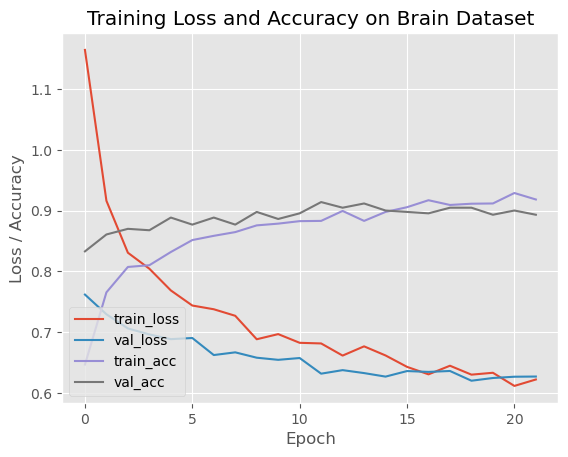

In [30]:
N = 22
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label= "train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label= "val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label= "train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label= "val_acc")
plt.title("Training Loss and Accuracy on Brain Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.legend(loc= "lower left")
plt.savefig("plot.jpg")

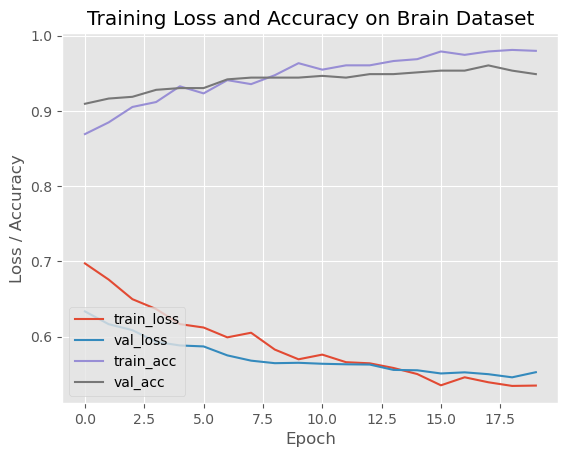

In [33]:
N = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_finetune.history["loss"], label= "train_loss")
plt.plot(np.arange(0, N), history_finetune.history["val_loss"], label= "val_loss")
plt.plot(np.arange(0, N), history_finetune.history["accuracy"], label= "train_acc")
plt.plot(np.arange(0, N), history_finetune.history["val_accuracy"], label= "val_acc")
plt.title("Training Loss and Accuracy on Brain Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.legend(loc= "lower left")
plt.savefig("plot.jpg")

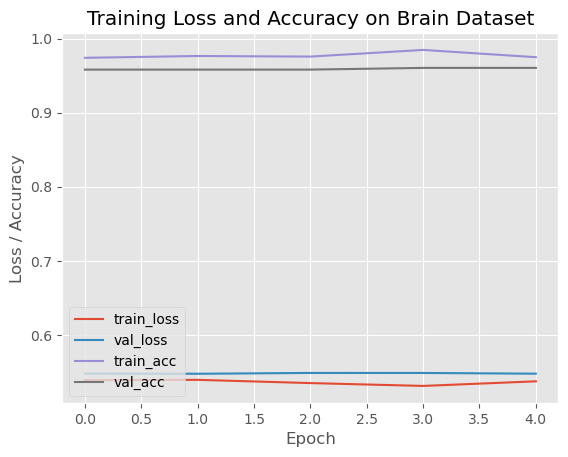

In [32]:
N = 5
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_final.history["loss"], label= "train_loss")
plt.plot(np.arange(0, N), history_final.history["val_loss"], label= "val_loss")
plt.plot(np.arange(0, N), history_final.history["accuracy"], label= "train_acc")
plt.plot(np.arange(0, N), history_final.history["val_accuracy"], label= "val_acc")
plt.title("Training Loss and Accuracy on Brain Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.legend(loc= "lower left")
plt.savefig("plot.jpg")

In [34]:
model.save("my_model.h5")

# Results
The model was trained in three phases:

1) Initial Training (30 epochs): Achieved validation accuracy of 0.9142.
2) Fine-Tuning (20 epochs): Improved validation accuracy to .
3) Final Training (5 epochs with ultra-low LR): Further improved test accuracy to 0.8122.

The training logs show consistent improvement in validation accuracy, peaking at 0.9675 in the final phase, with a validation loss of 0.5446. The use of data augmentation, class weights, and fine-tuning helped address class imbalance and improved generalization.